In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import ephem

from matplotlib.image import pil_to_array
from PIL import Image
from datetime import datetime, timedelta

def hard_sigmoid(x, s=10):
    return 1. / (1 + np.exp(-s * x))

def sun2lonlat(s, lonlat=False, show=False):
    lon, lat = s.az, s.alt
    colat = np.pi/2 - lat
#     while lat > 90 or lat < -90:
#         lat = 180 - lat
    if lon > 180.:
        lon -= 360.
    
    if show:
        print 'Sun:\tLon = %.2f\t Lat = %.2f\t Co-Lat = %.2f' %\
                (np.rad2deg(lon), np.rad2deg(lat), np.rad2deg(colat))
    
    if lonlat: # return the longitude and the latitude in degrees
        return np.rad2deg(lon), np.rad2deg(lat)
    else:      # return the lngitude and the co-latitude in radians
        return lon, colat

NSIDE = 32
zen = ephem.Observer()
sun = ephem.Sun()
edi = ephem.city("Edinburgh")
edi.date = datetime(2017, 6, 21, 0, 0, 0)

i = np.arange(hp.nside2npix(NSIDE))
theta, phi = hp.pix2ang(NSIDE, i) # return longitude and co-latitude in radians

view_rot = (0, 90, 0)

Sun:	Lon = 42.86	 Lat = -0.26	 Co-Lat = 90.26
Sun:	Lon = 78.58	 Lat = 20.83	 Co-Lat = 69.17
Sun:	Lon = 118.95	 Lat = 45.27	 Co-Lat = 44.73
Sun:	Lon = 184.82	 Lat = 57.43	 Co-Lat = 32.57
Sun:	Lon = 247.06	 Lat = 42.43	 Co-Lat = 47.57
Sun:	Lon = 285.84	 Lat = 17.76	 Co-Lat = 72.24


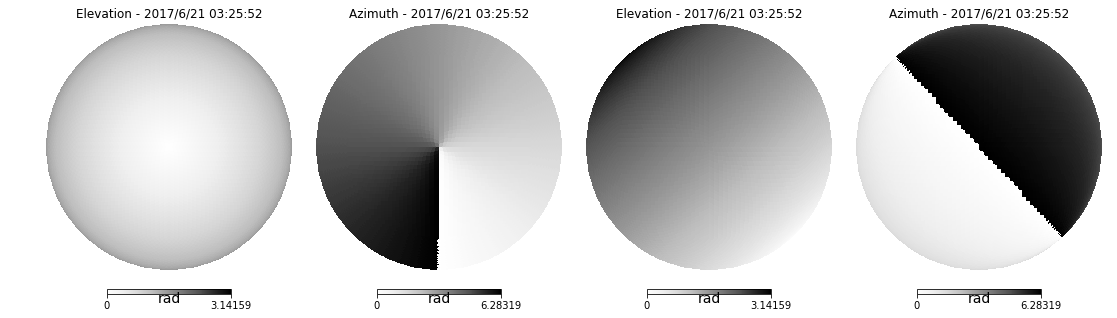

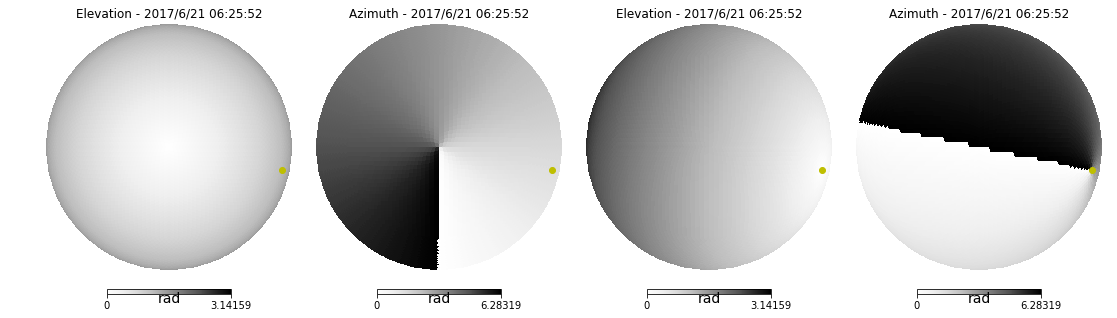

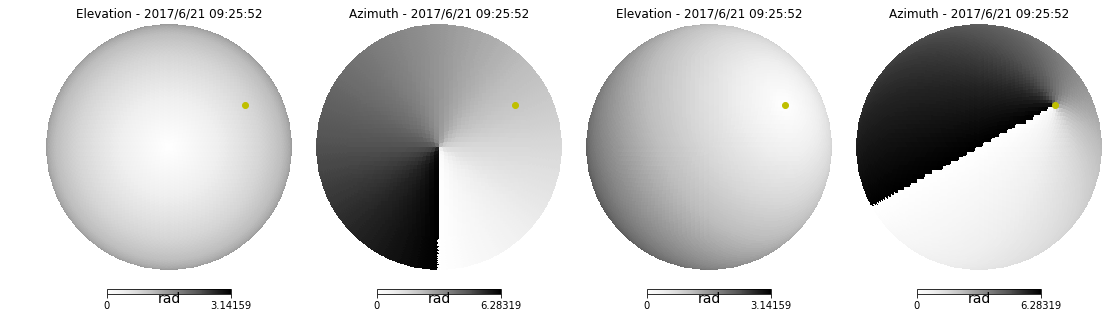

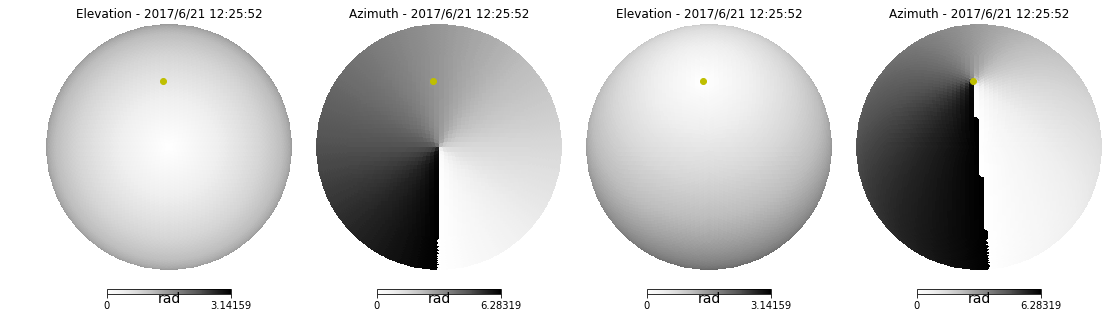

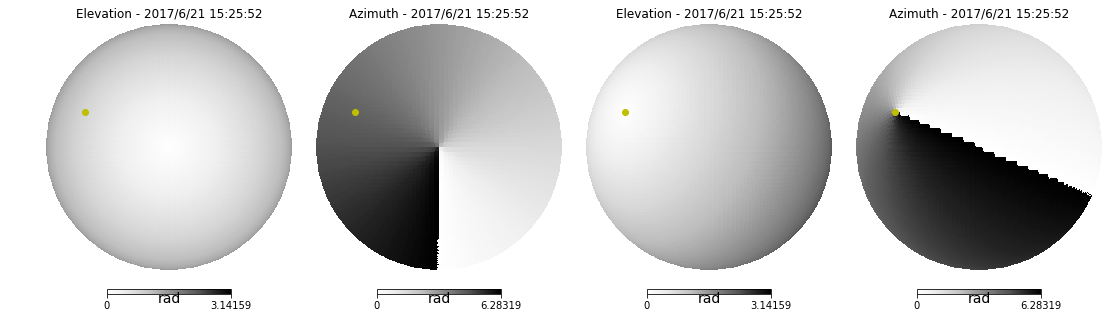

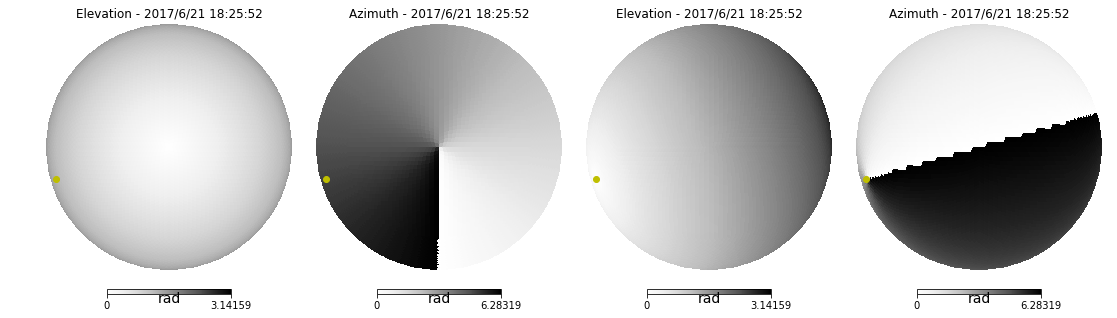

In [2]:
%matplotlib inline

edi.date = datetime(2017, 6, 21, 0, 0, 0)

cur = edi.next_rising(sun).datetime()
end = edi.next_setting(sun).datetime()
delta = timedelta(hours=3)
fig = 1
while cur <= end:
    edi.date = cur
    sun.compute(edi)
    lon, lat = sun2lonlat(sun, show=True)

    x, y, z = 0, np.rad2deg(lat), 180 + np.rad2deg(lon)
    el_sun, az_sun = hp.Rotator(rot=(z, y, x))(theta, phi)
    el_sun, az_sun = el_sun % np.pi, az_sun % (2 * np.pi)

    i_sun = np.argmin(el_sun)

    plt.figure(fig, figsize=(15, 5))
    hp.orthview(theta, rot=view_rot, min=0, max=np.pi, flip="geo", cmap="Greys", half_sky=True,
                   title="Elevation - %s" % str(edi.date), unit=r'rad', sub=(1,4,1), fig=1)
    hp.orthview(phi, rot=view_rot, min=0, max=2*np.pi, flip="geo", cmap="Greys", half_sky=True,
                   title="Azimuth - %s" % str(edi.date), unit=r'rad', sub=(1,4,2), fig=1)
    hp.orthview(el_sun, rot=view_rot, min=0, max=np.pi, flip="geo", cmap="Greys", half_sky=True,
                   title="Elevation - %s" % str(edi.date), unit=r'rad', sub=(1,4,3), fig=1)
    hp.orthview(az_sun, rot=view_rot, min=0, max=2*np.pi, flip="geo", cmap="Greys", half_sky=True,
                   title="Azimuth - %s" % str(edi.date), unit=r'rad', sub=(1,4,4), fig=1)
#     lon, lat = sun2lonlat(sun, lonlat=True, show=True)
#     hp.projplot(lon, lat, 'yo', lonlat=True, rot=view_rot)
    hp.projplot(lat, lon, 'yo', rot=view_rot)
    
    cur = cur + delta
    fig += 1

In [ ]:
edi.date = datetime(2017, 6, 21, 10, 0, 0)

sun.compute(edi)
lon, lat = sun2lonlat(sun, show=True)

x, y, z = 0, np.rad2deg(lat), 180 + np.rad2deg(lon)
el_sun, az_sun = hp.Rotator(rot=(z, y, x))(theta, phi)
el_sun, az_sun = el_sun % np.pi, az_sun % (2 * np.pi)

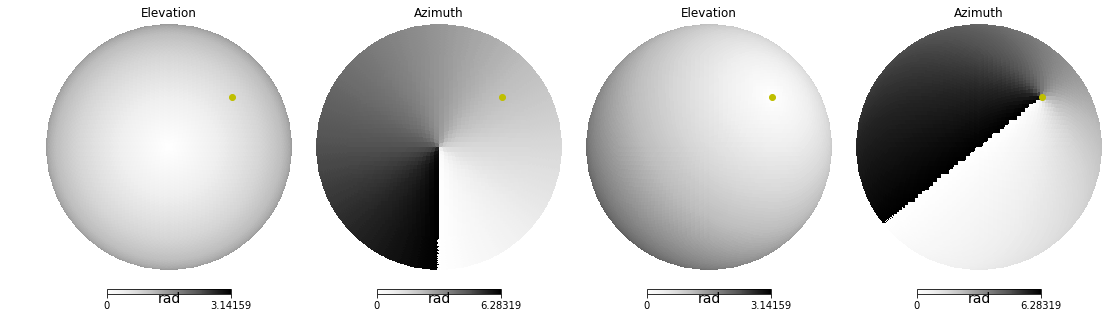

In [31]:
plt.figure(1, figsize=(15, 5))
hp.orthview(theta, rot=view_rot, min=0, max=np.pi, flip="geo", cmap="Greys", half_sky=True,
               title="Elevation", unit=r'rad', sub=(1,4,1), fig=1)
hp.orthview(phi, rot=view_rot, min=0, max=2*np.pi, flip="geo", cmap="Greys", half_sky=True,
               title="Azimuth", unit=r'rad', sub=(1,4,2), fig=1)
hp.orthview(el_sun, rot=view_rot, min=0, max=np.pi, flip="geo", cmap="Greys", half_sky=True,
               title="Elevation", unit=r'rad', sub=(1,4,3), fig=1)
hp.orthview(az_sun, rot=view_rot, min=0, max=2*np.pi, flip="geo", cmap="Greys", half_sky=True,
               title="Azimuth", unit=r'rad', sub=(1,4,4), fig=1)
hp.projplot(lat, lon, 'yo')

In [52]:
def rayleigh(x, sigma=np.pi/2):
    x = np.absolute(x)
    return (x / np.square(sigma)) * np.exp(-np.square(x) / (2 * np.square(sigma)))

def f_phi(z, a=0., b=-1.):
    """
    The luminance gradation function relates the luminance of a sky element to its zenith angle.
    """
    p = np.zeros_like(z)
    z_p = np.all([z >= 0, z < np.pi/2], axis=0)
    p[z_p] = 1. + a * np.exp(b / np.cos(z[z_p]))
    p[np.isclose(z, np.pi/2)] = 1.
    return p 

def f(chu, c=0., d=-1., e=0.):
    """
    The scattering indicatrix which relates the relative luminance of the sky element
    to its angular distance from the sun.
    """
    return 1. + c * (np.exp(d * chu) - np.exp(d * np.pi / 2)) + e * np.square(np.cos(chu))

def L_z(chu, Z, a=-1., b=-.55, c=10., d=-3., e=.45):
    return f(chu, c, d, e) * f_phi(Z, a, b)

def L_gamma_alpha(chu, Z, Zs, a=-1, b=-.55, c=10., d=-3., e=.45):
    return L_z(chu, Z, a, b, c, d, e) / L_z(Zs, np.zeros(1), a, b, c, d, e)

def Colour_Temperature(L, alpha=-132.1, beta=59.77):
    T = np.zeros(L)
    T[L > 0] = -alpha + beta * np.log(L[L > 0])
    return T

sun_dir = 2 * (hard_sigmoid(np.pi/2 - el_sun) - .5)
SIF = f(el_sun, c=10., d=-3, e=.45)
LGF = f_phi(theta, a=-1., b=-.55)
L = L_z(el_sun, theta)
T = Colour_Temperature(L)

DOP = 2 * rayleigh(el_sun)
AOP = (az_sun + np.pi/2) % np.pi
# rel_luminance = L_gamma_alpha(el_sun, theta, hp.rotator.angdist([lon, lat], [0., 0.]))
print "Maximum polarisation degree =", DOP.max()
print "Maximum luminance", L.max()
print "Maximum temperature", T.max()
# print "Maximum relative luminance", rel_luminance.max()

Maximum polarisation degree = 0.772258699392
Maximum luminance 5.6775692664
Maximum temperature 235.89199137


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log


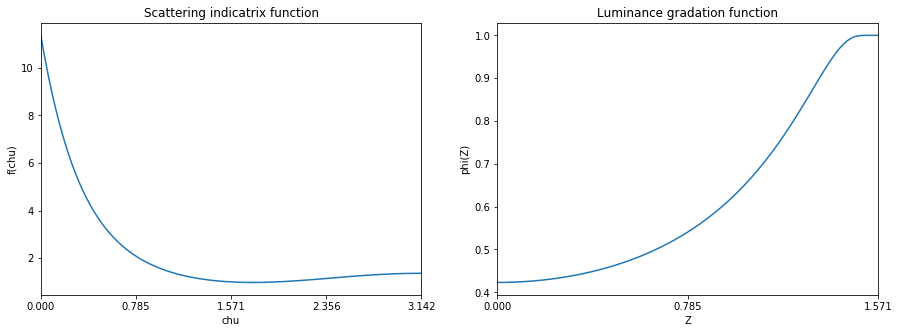

In [59]:
plt.figure(1, figsize=(15, 5))
chu = np.linspace(0, np.pi, 100, endpoint=True)
Z = np.linspace(0, np.pi/2, 100, endpoint=True)
plt.subplot(1,2,1)
plt.title("Scattering indicatrix function")
plt.xlabel("chu")
plt.ylabel("f(chu)")
plt.plot(chu, f(chu, c=10., d=-3, e=.45))
plt.xlim([0,np.pi])
plt.xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
plt.subplot(1,2,2)
plt.title("Luminance gradation function")
plt.xlabel("Z")
plt.ylabel("phi(Z)")
plt.plot(Z, f_phi(Z, a=-1., b=-.55))
plt.xlim([0,np.pi/2])
plt.xticks([0, np.pi/4, np.pi/2])
plt.show()

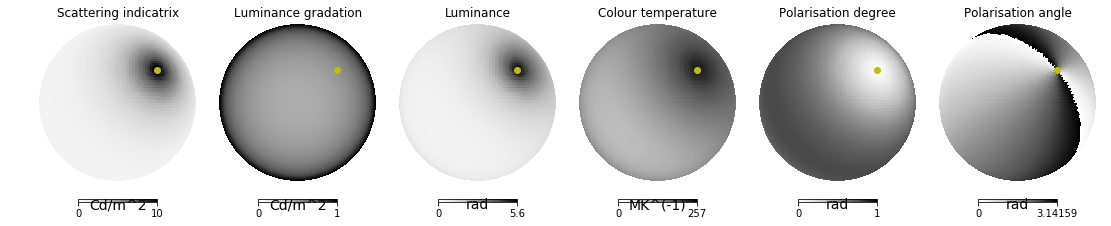

In [54]:
plt.figure(1, figsize=(15, 5))
hp.orthview(SIF, rot=view_rot, min=0, max=10, flip="geo", cmap="Greys", half_sky=True,
               title="Scattering indicatrix", unit=r'Cd/m^2', sub=(1,6,1), fig=1)
hp.orthview(LGF, rot=view_rot, min=0, max=1, flip="geo", cmap="Greys", half_sky=True,
               title="Luminance gradation", unit=r'Cd/m^2', sub=(1,6,2), fig=1)
hp.orthview(L, rot=view_rot, min=0, max=5.6, flip="geo", cmap="Greys", half_sky=True,
               title="Luminance", unit=r'rad', sub=(1,6,3), fig=1)
hp.orthview(T, rot=view_rot, min=0, max=257, flip="geo", cmap="Greys", half_sky=True,
               title="Colour temperature", unit=r'MK^(-1)', sub=(1,6,4), fig=1)
hp.orthview(DOP, rot=view_rot, min=0, max=1, flip="geo", cmap="Greys", half_sky=True,
               title="Polarisation degree", unit=r'rad', sub=(1,6,5), fig=1)
hp.orthview(AOP, rot=view_rot, min=0, max=np.pi, flip="geo", cmap="Greys", half_sky=True,
               title="Polarisation angle", unit=r'rad', sub=(1,6,6), fig=1)
hp.projplot(lat, lon, 'yo')